In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, train_test_split
from sklearn.linear_model import Ridge, Lasso, LogisticRegression # NOT the CV objects, models themselves
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, mean_absolute_error, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

## 1) Cross-validation for a Regression Task

In this question, you will focus on lower-level cross-validation tools for a regression task.

Read the data from **soc_ind.csv**. Each observation is a country and each variable is a social indicator. The variable names should be self-explanatory.

In [116]:
data = pd.read_csv('soc_ind.csv')
data.head()

,Index,continent,geographic_location,country,economicActivityFemale,economicActivityMale,gdpPerCapita,illiteracyFemale,illiteracyMale,infantMortality,lifeFemale,lifeMale
0,1,Asia,Western Asia,Yemen,1.9,80.6,1924,69.552,32.406,80,58.4,57.4
1,2,Asia,Western Asia,Saudi Arabia,6.9,78.8,48099,49.800,28.500,23,73.4,69.9
2,3,Asia,Southern Asia,Afghanistan,7.2,87.5,2474,85.000,52.800,154,46.0,45.0
3,4,Africa,Northern Africa,Algeria,7.8,76.4,11433,51.000,26.100,44,70.3,67.5
4,5,Asia,Southern Asia,Iran,9.9,79.8,13513,40.700,22.300,39,70.0,68.5


### a)

Create two [density](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) plots: One with the `gdpPerCapita` variable and one with its log-transformed version. Which one should be used as the response for a regression task? Justify your answer. **(3 points)**

**Note:** Use `np.log`

Text(0.5, 0, 'log (GDP per Capita)')

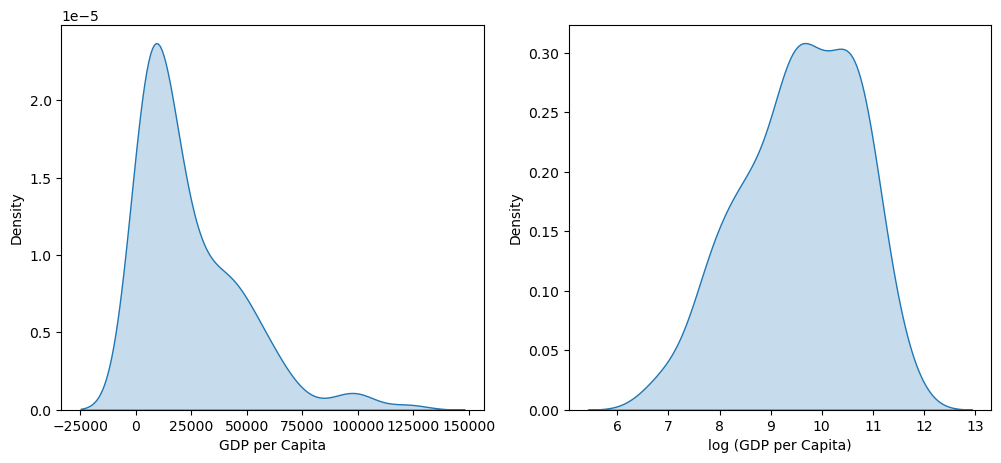

In [119]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.kdeplot(data.gdpPerCapita, fill=True)
plt.xlabel('GDP per Capita')


plt.subplot(1, 2, 2)
sns.kdeplot(np.log(data.gdpPerCapita), fill=True)
plt.xlabel('log (GDP per Capita)')

Log-transformed GDP per capita should be used at the response variable since it has a more balanced distribution. The log distribution is more similar to a normal distribution, so it may be more informative of the underlying trend.

### b)

Create the proper response variable based on your answer in Part a. The predictors are the rest of the variables except `Index`, `geographic_location`, and `country`. Create a predictor matrix accordingly. **(2 points)**

Using the `train_test_split` function from `sklearn.model_selection`, create the training and the test data. (You may need to read its [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).) Use a 80%-20% train-test split and use `random_state=2` for reproducible results. **(2 points)**

In [123]:
X = data.drop(['Index','geographic_location','country','gdpPerCapita'],axis=1)
y = np.log(data['gdpPerCapita'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

### c)

One-hot-encode and scale (in this order) both the training and the test data. 

**Note:** Use `drop_first=True`.

**(2 points)**

In [126]:
# OHE
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test,drop_first=True)

# scaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### d)

Tune a ridge regression model with the following specifications:

- A hyperparameter vector of `np.logspace(2,0.5,200)`
- 10-fold cross-validation (CV)
- `neg_mean_absolute_error` as the scoring metric

Save all your CV scores in a numpy array. **You must use `cross_val_score` (properly) for credit.**

**(5 points)**

In [129]:
alphas = np.logspace(2,0.5,200)

cv_scores = []


for alpha in alphas:
    model = Ridge(alpha=alpha)
    cv_score = cross_val_score(model, X_train_scaled, y_train, cv = 10, scoring = 'neg_mean_absolute_error')
    cv_scores.append(cv_score)
    
avg_cv_results = -np.array(cv_scores).mean(axis=1)



### e)

Using the numpy array created in Part d, find the tuned hyperparameter value and the best average CV score that corresponds to it. **(2 points)**

In [132]:
print('Best avg cv performance:', np.min(avg_cv_results))
print('Best hyperparam:', alphas[np.argmin(avg_cv_results)])



Best avg cv performance: 0.48459068222504875
Best hyperparam: 8.959036511956615


### f)

Interpret the best average CV score in Part e. Is it actually the average error in GDP per capita values? What seems to be the issue with it? **(2 points)**

The best average CV score is extremely low, around 0.5. This is the average error in log GDP per capita values, so it is misleadingly low.

### g)

Train a final ridge regression model with the tuned hyperparameter value found in Part e. Return the test Mean Absolute Error (MAE). **You must return the test MAE of the actual GDP per capita values for credit.** **(3 points)**

In [137]:
alpha = alphas[np.argmin(avg_cv_results)]

tuned_model = Ridge(alpha = alpha)
tuned_model.fit(X_train_scaled, y_train)


y_pred = np.exp(tuned_model.predict(X_test_scaled))

test_mae = mean_absolute_error(y_test, y_pred)
print('Test MAE:', test_mae)


Test MAE: 17621.981108786138


### h)

Repeat the tuning process in Part d with the same specifications. However, instead of saving the CV scores, save all the CV predictions in a numpy array. **You must use `cross_val_predict` (properly) for credit.**

Note that the main goal of this and the following parts is to tune the model with the CV MAE of the actual GDP per capita values.

**(5 points)**

In [140]:
cv_preds = []
alphas = np.logspace(2,0.5,200)

for alpha in alphas:
    model = Ridge(alpha=alpha)
    cv_pred = cross_val_predict(model, X_train_scaled, y_train, cv = 10)

    cv_preds.append(cv_pred)

# convert  log predictions into the linear scale 
cv_pred_errors = np.exp(np.array(cv_preds)) - np.array(np.exp(y_train))

# calculate MAE for each alpha
cv_maes = np.abs(cv_pred_errors).mean(axis=1)

cv_maes

array([10874.92558746, 10852.80163658, 10830.72863928, 10808.70816687,
       10786.74178738, 10764.8310654 , 10742.97756185, 10721.18283382,
       10699.44843426, 10677.77591174, 10656.16681019, 10634.6226686 ,
       10613.14502066, 10591.73539447, 10570.39531216, 10549.12628954,
       10527.92983567, 10506.80745251, 10485.76063445, 10464.79086792,
       10443.89963089, 10423.08839243, 10402.35861226, 10381.71174019,
       10361.1492157 , 10340.67246738, 10320.28291241, 10299.98195604,
       10279.77099106, 10259.65139727, 10239.62454086, 10219.69177395,
       10199.85443397, 10180.1138431 , 10160.47130776, 10140.92811798,
       10121.48554687, 10102.14485006, 10082.90726514, 10063.80639792,
       10044.83784737, 10025.97398789, 10007.21601665,  9988.56510965,
        9970.02242112,  9951.7284774 ,  9933.67217101,  9915.72538944,
        9897.88920424,  9880.16466278,  9862.59418326,  9845.20271272,
        9827.92388904,  9810.75868451,  9794.15904665,  9778.19902274,
      

### i)

Using the numpy array created in Part h, find the tuned hyperparameter value and the best average CV score that corresponds to it.

You should see a tuned hyperparameter value different than in Part e and a best average CV score that actually represents the average error in GDP per capita values. 

**(4 points)**

In [142]:
print('Best avg cv performance:', np.min(cv_maes))
print('Best hyperparam:', alphas[np.argmin(cv_maes)])



Best avg cv performance: 8974.028120572799
Best hyperparam: 3.6333020805204432


### j)

Train a final ridge regression model with the tuned hyperparameter value found in Part i. Return the test Mean Absolute Error (MAE). **You must return the test MAE of the actual GDP per capita values for credit.** 

How does the test MAE in this part compare to the test MAE in Part g? Why do you think this is the case?

**(4 points)**

In [146]:
alpha = alphas[np.argmin(cv_maes)]

tuned_model = Ridge(alpha=alpha)
tuned_model.fit(X_train_scaled, y_train)


y_pred = tuned_model.predict(X_test_scaled)

test_mae = mean_absolute_error(np.exp(y_test), np.exp(y_pred))


print('Test MAE:', test_mae)


Test MAE: 9869.168574969644


Test MAE here is slightly lower than in part g. The earlier model was tuned using cross_val_score, which does not provide scores based on the actual prediction values of GDP per capita, so its output differs from the model here. Since this model was tuned according to the actual MAE for real GDP per capita values, it performs slightly better.

## 2) Cross-validation for a Classification Task (36 points)

In this question, you will focus on lower-level cross-validation tools for a classification task.

Read the data from **diabetes_train.csv** and **diabetes_test.csv**. Each observation is a patient. The `Outcome` variable represents whether the patient has diabetes (1) or not (0). The rest of the variables should be self-explanatory.

In [151]:
train = pd.read_csv('diabetes_train.csv')
test = pd.read_csv('diabetes_test.csv')
train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,88,74,19,53,29.0,0.229,22,0
1,2,129,84,0,0,28.0,0.284,27,0
2,0,102,78,40,90,34.5,0.238,24,0
3,0,123,72,0,0,36.3,0.258,52,1
4,1,144,82,46,180,46.1,0.335,46,1


### a)

Create the training and test data. `Outcome` is the response and all the other variables are the predictors. **(2 points)**

In [154]:
X_train = train.drop(['Outcome'], axis=1)
y_train = train['Outcome']

X_test = test.drop(['Outcome'], axis=1)
y_test = test['Outcome']

### b)

Scale the training and the test data. **(1 point)**

In [157]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### c)

Tune a lasso classification model (with `solver=saga`) with the following specifications:

- A hyperparameter vector of `np.logspace(2,-2,200)`
- 5-fold cross-validation (CV)
- Accuracy, which is the default input, as the scoring metric

Save all your CV scores in a numpy array. **You must use `cross_val_score` (properly) for credit.**

**(5 points)**

In [160]:
Cs = np.logspace(2,-2,200)
cv_scores = []

for C in Cs:
    model = LogisticRegression(penalty = 'l1', C=C, solver='saga')
    cv_score = cross_val_score(model, X_train_scaled, y_train, cv=5)
    cv_scores.append(cv_score)

avg_cv_scores = np.array(cv_scores).mean(axis=1)



### d)

Using the numpy array created in Part c, find the tuned hyperparameter value and the best average CV score that corresponds to it. **(2 points)**

In [163]:
print('Best avg cv performance:', np.max(avg_cv_scores))
print('Best C value:', Cs[np.argmax(avg_cv_scores)])



Best avg cv performance: 0.7687591630014661
Best C value: 0.8119844993184009


### e)

Train a final lasso classification model with the tuned hyperparameter value found in Part d. Using a decision threshold of 0.5, return the test accuracy and test recall. Return the test AUC as well. Which metric returns a lower performance than the others?

**(5 points)**

In [166]:
C = Cs[np.argmax(avg_cv_scores)]

tuned_model = LogisticRegression(penalty = 'l1', C=C, solver='saga')
tuned_model.fit(X_train_scaled, y_train)


y_pred_probs = tuned_model.predict_proba(X_test_scaled)[:,1]


print('Test accuracy:', accuracy_score(y_test, y_pred_probs > 0.5))
print('Test recall:', recall_score(y_test, y_pred_probs > 0.5))
print('Test AUC:', roc_auc_score(y_test, y_pred_probs > 0.5))







Test accuracy: 0.7922077922077922
Test recall: 0.5901639344262295
Test AUC: 0.7574475586109641


Recall is significantly lower than accuracy and AUC.

### f)

What was the decision threshold used to find the CV scores in Part c? How did it contribute to the low performance in Part e? **(2 points)**

The decision threshold used in part c was 0.5, the default. Since this value was not tuned separately or in tandem with the hyperparameter, the model's performance was limited.

### g)

Recreate the tuned lasso classification model from Part e. Using this model, return the **CV prediction probabilities** for the best hyperparameter value found in Part d. Save all the CV prediction probabilities in a numpy array. **You must use `cross_val_predict` (properly) for credit.**

Note that the main goal of this and the following parts is to tune the decision threshold by using the CV prediction probabilities.

**(3 points)**

In [172]:
tuned_model = LogisticRegression(penalty = 'l1', C=C, solver='saga')
tuned_model.fit(X_train_scaled, y_train)

cv_pred_probs = np.array(cross_val_predict(tuned_model, X_train_scaled, y_train, cv=5, method = 'predict_proba'))
cv_pred_probs

array([[0.94988526, 0.05011474],
       [0.81355881, 0.18644119],
       [0.90997698, 0.09002302],
       ...,
       [0.91094125, 0.08905875],
       [0.53258248, 0.46741752],
       [0.79443514, 0.20556486]])

### h)

Using the numpy array created in Part g, calculate and store the CV accuracy, CV recall and CV AUC for all possible threshold values from 0 to 1 with a stepsize of 0.001. 

**Note:** Be careful with AUC.

**(4 points)**

In [175]:
thrs = np.arange(0,1,0.001)
accs = []
recs = []
aucs = []

for thr in thrs:
    accs.append(accuracy_score(y_train, cv_pred_probs[:,1] > thr))
    recs.append(recall_score(y_train, cv_pred_probs[:,1] > thr))
    aucs.append(roc_auc_score(y_train, cv_pred_probs[:,1]))


### i)

Plot the accuracy, recall and AUC values found in Part h (y-axis) against the threshold (x-axis) on the same graph. Include a legend. **(3 points)**

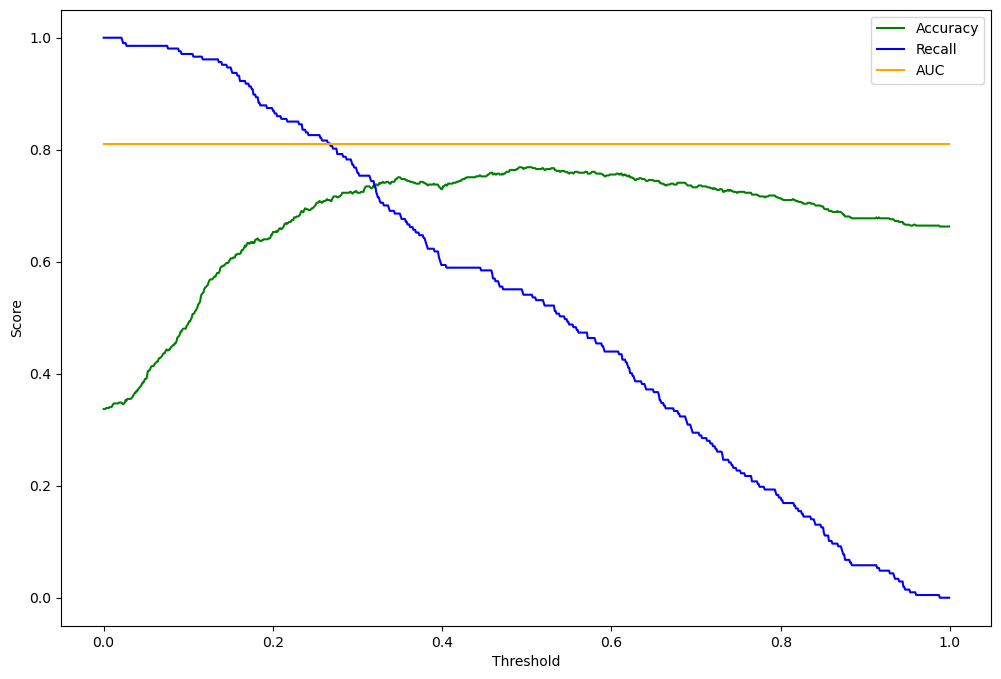

In [178]:
plt.figure(figsize=(12,8))
plt.plot(thrs, accs, label='Accuracy', color='green')
plt.plot(thrs, recs, label='Recall', color='blue')
plt.plot(thrs, aucs, label='AUC', color = 'orange')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.show()

### j)

In the plot in Part i, you should see a threshold value where the accuracy and recall values are the same. Find that value. 

**Note:** You need to round the accuracy and recall values to 2 decimal digits to find the threshold. In other words, round them to integers if you are using the scores as percentages.

**(3 points)**

In [181]:
score_df = pd.DataFrame(columns = ['accuracy', 'recall', 'auc','threshold'])
score_df.threshold = thrs
score_df.accuracy = np.round(accs,2)
score_df.recall = np.round(recs,2)
score_df.auc = aucs

print(score_df.loc[score_df.accuracy == score_df.recall])

print('Threshold value found is 0.319.')

     accuracy  recall       auc  threshold
319      0.74    0.74  0.810289      0.319
Threshold value found is 0.319.


### k)

Recreate the tuned lasso classification model from Part e. Using the threshold value found in Part j, return the test accuracy and test recall. Also return the test AUC. **(3 points)**

How do the accuracy and recall compare to Part e? **(1 point)** Did AUC change? **(1 point)** Why or why not? **(1 point)**

In [184]:
tuned_model = LogisticRegression(penalty = 'l1', C=C, solver='saga')
tuned_model.fit(X_train_scaled, y_train)


y_pred_probs = tuned_model.predict_proba(X_test_scaled)[:,1]


print('Test accuracy:', accuracy_score(y_test, y_pred_probs > 0.319))
print('Test recall:', recall_score(y_test, y_pred_probs > 0.319))
print('Test AUC:', roc_auc_score(y_test, y_pred_probs > 0.319))





Test accuracy: 0.7727272727272727
Test recall: 0.7868852459016393
Test AUC: 0.7751630530583465


## 3) Outliers and Multicollinearity (27 points)

In this question, you will analyze how removing the unnecessary observations and predictors can improve the prediction and the inference performance of a model. 

Read the data from **Austin_Affordable_Housing_Train.csv** and **Austin_Affordable_Housing_Test.csv**. Each observation represents a housing development in Austin, TX. The `City_Amount` variable represents the amount (in USD) provided by the city of Austin for the development. This variable will be the response for the regression task.

In [188]:
train = pd.read_csv('Austin_Affordable_Housing_Train.csv')
test = pd.read_csv('Austin_Affordable_Housing_Test.csv')
test.head()

,Unnamed: 0,Zip_Code,Council_District,Total_Units,Total_Affordable_Units,Total_Accessible_Units,Total_Permanent_Support,Unit_Type,Tenure,Status,Affordability_Start_Year,Affordability_Expiration_Year,Affordability_Period,Units_Under_50_Percent_MFI,Market_Rate_Units,Voluntary,City_Amount
0,200,78702,1,3,0.0,0.0,0.0,Multifamily,Ownership,7. Project Completed,2000,2099,99,0,3,No,3962717.0
1,201,78745,2,20,20.0,16.0,4.0,Multifamily,Rental,6. Building Permit Issued,2015,2055,40,16,0,No,1376070.0
2,202,78745,5,4,3.0,0.0,0.0,FourPlex,Rental,7. Project Completed,2015,2114,99,3,1,No,257775.0
3,203,78741,3,14,14.0,1.0,0.0,Multifamily,Rental,7. Project Completed,2001,2021,20,14,0,No,500000.0
4,204,78721,3,97,97.0,12.0,4.0,Multifamily,Rental,1. Certified/Loan Executed,2000,2040,40,62,0,No,1600000.0


### a)

Using statsmodels, create and train a **linear** regression model that predicts `City_Amount` using `Market_Rate_Units`, `Total_Affordable_Units`, `Total_Accessible_Units`, and `Total_Units` as the four predictors. Do not include any interaction terms. Do not transform any predictors or the response.

Print the model summary. Which predictor is statistically insignificant? **(3 points)**

In [191]:
model = smf.ols('City_Amount ~ Market_Rate_Units + Total_Affordable_Units + Total_Accessible_Units + Total_Units', data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            City_Amount   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     57.87
Date:                Sun, 09 Mar 2025   Prob (F-statistic):           3.94e-32
Time:                        13:39:20   Log-Likelihood:                -3045.5
No. Observations:                 200   AIC:                             6101.
Df Residuals:                     195   BIC:                             6117.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               2.597e+05   7.94e+04      3.272      0.001    1.03e+05    4.16e+05
Market_Rate_Units       3.364e+04   1.67e+04      2.016      0.045     738.065    6.66e+04
Total_Affordable_Units   4.42e+04   1.73e+04      2.554      0.011    1.01e+04    7.83e+04
Total_Accessible_Units -6.286e+04   1.76e+04     -3.572      0.000   -9.76e+04   -2.82e+04
Total_Units            -2.135e+04   1.66e+04     -1.288      0.199    -5.4e+04    1.13e+04
==============================================================================
Omnibus:                       90.625   Durbin-Watson:                   1.389
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1222.692
Skew:                           1.312   Prob(JB):                    3.13e-266
Kurtosis:                      14.825   Cond. No.                         103.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Total_Units is statistically insignificant.

### b)

Print the test RMSE of the model created in Part a. This will be used for comparison in the following parts of this question. **(1 point)**

In [195]:
pred = model.predict(test)
print(f' RMSE:  {np.sqrt(np.mean((test.City_Amount - pred)**2))}')

 RMSE:  816092.4425553235


### c)

To dive deeper into the statistical significance of the four predictors, create their correlation matrix first. **(1 point)** How many pairs seem to be highly  correlated? (Define high correlation as the coefficient above 0.5.) **(1 point)** Why is this matrix not useful to detect multicollinearity in the model? **(2 points)**

In [198]:
train[['Market_Rate_Units', 'Total_Affordable_Units', 'Total_Accessible_Units', 'Total_Units']].corr(numeric_only=True)

,Market_Rate_Units,Total_Affordable_Units,Total_Accessible_Units,Total_Units
Market_Rate_Units,1.000000,0.272216,0.275496,0.627616
Total_Affordable_Units,0.272216,1.000000,0.686937,0.917180
Total_Accessible_Units,0.275496,0.686937,1.000000,0.654937
Total_Units,0.627616,0.917180,0.654937,1.000000


There appear to be 3 highly correlated pairs: 1) Total_Affordable_Units & Total_Accessible_Units, 2) Total_Affordable_Units & Total_Units, and 3) Market_Rate_Units & Total_Units. This is not useful to detect multico. in the model since it only considers pairwise correlations.

### d)

Create the Variation Inflation Factor (VIF) table of the predictors. **(1 point)** Is there multicollinearity in the data? **(1 point)**

In [202]:
X = train[['Market_Rate_Units', 'Total_Affordable_Units', 'Total_Accessible_Units', 'Total_Units']]

X_const = add_constant(X)

vif_data = pd.DataFrame() # empty df
vif_data['variable'] = X_const.columns # Put the names in the first col

for i in range(len(X_const.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X_const.values, i)

vif_data

,variable,VIF
0,const,1.245882
1,Market_Rate_Units,40.571755
2,Total_Affordable_Units,159.751905
3,Total_Accessible_Units,2.033927
4,Total_Units,234.528279


Yes - all variables have VIF > 10 besides total_accessible_units.

### e)

Remove the predictor with the highest VIF and print the VIF table again. **(1 point)** Is there any multicollinearity left? **(1 point)**

In [206]:
X = train[['Market_Rate_Units', 'Total_Accessible_Units', 'Total_Affordable_Units']]

X_const = add_constant(X)

vif_data = pd.DataFrame() # empty df
vif_data['variable'] = X_const.columns # Put the names in the first col

for i in range(len(X_const.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X_const.values, i)

vif_data

,variable,VIF
0,const,1.245881
1,Market_Rate_Units,1.097613
2,Total_Accessible_Units,1.924340
3,Total_Affordable_Units,1.920606


There is low, acceptable multicollinearity. For the sake of analysis, no.

### f)

Recreate and retrain the linear regression model from Part a, this time only using the remaining three predictors from Part e. Print the model summary and the test RMSE. **(2 points)** How did the p-values of the remaining predictors change, compared to the model in Part a? **(1 point)** How about the test RMSE, compared to Part b? **(1 point)** What is the reason behind these changes? **(2 points)**

In [210]:
model = smf.ols('City_Amount ~ Market_Rate_Units + Total_Accessible_Units + Total_Affordable_Units', data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            City_Amount   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     76.35
Date:                Sun, 09 Mar 2025   Prob (F-statistic):           9.37e-33
Time:                        13:39:27   Log-Likelihood:                -3046.3
No. Observations:                 200   AIC:                             6101.
Df Residuals:                     196   BIC:                             6114.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               2.596e+05   7.95e+04      3.266      0.001    1.03e+05    4.16e+05
Market_Rate_Units       1.245e+04   2749.012      4.528      0.000    7026.605    1.79e+04
Total_Accessible_Units  -5.76e+04   1.71e+04     -3.359      0.001   -9.14e+04   -2.38e+04
Total_Affordable_Units  2.205e+04   1900.822     11.599      0.000    1.83e+04    2.58e+04
==============================================================================
Omnibus:                       97.134   Durbin-Watson:                   1.377
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1292.399
Skew:                           1.456   Prob(JB):                    2.29e-281
Kurtosis:                      15.108   Cond. No.                         65.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [212]:
pred = model.predict(test)
print(f' RMSE:  {np.sqrt(np.mean((test.City_Amount - pred)**2))}')

 RMSE:  806198.4663491294


All p values are < 0.05 now. Test RMSE is also lower than in part a. The model is performing better after addressing the multicollinearity in the predictors.

### g)

Now that the problematic predictor is discarded, it is time to clean out the observations. Using the model trained in Part f, find the influential points in the training dataset and filter them out. **(3 points)** How many observations did you discard? **(1 point)**

In [216]:
out = model.outlier_test()

out 
N = train.shape[0] 
df = model.df_model # degrees of freedom in the model
alpha=0.05

from scipy import stats
critical_val = stats.t.ppf(1-alpha/2, N-df-1)


influence = model.get_influence()
leverage = influence.hat_matrix_diag
avg_leverage = (df+1)/N 



(np.abs(out.student_resid) > critical_val) & (leverage > 4*avg_leverage)

print(np.sum((np.abs(out.student_resid) > critical_val) & (leverage > 4*avg_leverage)))

train_clean = train[~((np.abs(out.student_resid) > critical_val) & (leverage > 4*avg_leverage))]

6


6 observations discarded.

### h)

Recreate and retrain the linear regression model from Part f, using the clean training dataset (with the influential points filtered out). Print the summary and the test RMSE. **(1 point)** How did the R-squared of the model change, compared to the model in Part f? **(1 point)** How about the test RMSE? **(1 point)** What is the reason behind these changes? **(2 points)**

In [220]:
model = smf.ols('City_Amount ~ Market_Rate_Units + Total_Accessible_Units + Total_Affordable_Units', data=train_clean).fit()
print(model.summary())


pred = model.predict(test)
print(f' RMSE:  {np.sqrt(np.mean((test.City_Amount - pred)**2))}')

                            OLS Regression Results                            
Dep. Variable:            City_Amount   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     115.5
Date:                Sun, 09 Mar 2025   Prob (F-statistic):           1.34e-42
Time:                        13:39:32   Log-Likelihood:                -2874.3
No. Observations:                 194   AIC:                             5757.
Df Residuals:                     190   BIC:                             5770.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               1.99

R-squared is higher and test RMSE is lower than in the model from part f. This is because discarding influential points improves the prediction performance of the model, and allows the model to better explain the variation in the data.